In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test3 import Test
from bitalg.visualizer.main import Visualizer
%matplotlib widget

In [29]:
def mat_det_2x2(p1,p2,p3):
    return ((p1.x-p3.x)*(p2.y-p3.y)-(p1.y-p3.y)*(p2.x-p3.x))

Implementacja Algorytmu Delaunaya

In [30]:
from queue import PriorityQueue
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib.patches import Circle

In [31]:
def mat_det_2x2(p1,p2,p3):
    return ((p1.x-p3.x)*(p2.y-p3.y)-(p1.y-p3.y)*(p2.x-p3.x))

In [32]:
class Point:
    def __init__(self,x,y):
        self.x=x
        self.y=y

In [33]:
class Edge:
    def __init__(self,p_index1,p_index2):
        self.p_index1=min(p_index1,p_index2)
        self.p_index2=max(p_index1,p_index2)
        self.friendTriangle1=None
        self.friendTriangle2=None
        if(p_index1<0 and p_index2<0):
            self.edgeType="External"
        elif((p_index1<0 and p_index2>=0) or (p_index1>=0 and p_index2<0)):
            self.edgeType="HalfExternal"
        else:
            self.edgeType="Internal"
    def __eq__(self,other):
        return (self.p_index1==other.p_index1 and self.p_index2==other.p_index2) or (self.p_index1==other.p_index2 and self.p_index2==other.p_index1)
    def __hash__(self):
        return hash(self.p_index1)^hash(self.p_index2)
    def setFriends(self,f1,f2):
        self.friendTriangle1=f1
        self.friendTriangle2=f2
    def updateFriend(self,oldFriend,newFriend):
        if oldFriend==self.friendTriangle1:
            self.friendTriangle1=newFriend
        elif oldFriend==self.friendTriangle2:
            self.friendTriangle2=newFriend
class Triangle:
    def __init__(self,e1,e2,e3):
        self.Edges=[e1,e2,e3]
        self.points=None
        self.visited=-1
        self.activated=True
    def setPoints(self,x,y,z,Tpoints):
        self.points=sorted([x,y,z])
        self.center=Point((Tpoints[x].x+Tpoints[y].x+Tpoints[z].x)/3,(Tpoints[x].y+Tpoints[y].y+Tpoints[z].y)/3)
    def __str__(self):
        if(self.points==None or self==None):
            return str("None")
        return ("("+str(self.points[0])+","+str(self.points[1])+","+str(self.points[2])+")")
        

In [34]:

class Delaunay:
    def __init__(self,points):
        
        self.it=0
        self.n=len(points)
        self.vis=Visualizer()
        self.M=0
        for x,y in points:
            self.M=max(abs(x),abs(y),self.M)
        self.Tpoints={}
        self.Tpoints[-3]=Point(-3*self.M,-3*self.M)
        self.Tpoints[-2]=Point(0,3*self.M)
        self.Tpoints[-1]=Point(3*self.M,0)
        for i in range(0,self.n):
            self.Tpoints[i]=Point(points[i][0],points[i][1])
        self.vis.add_line_segment(((-3*self.M,-3*self.M),(0,3*self.M)),color='Green')
        self.vis.add_line_segment(((0,3*self.M),(3*self.M,0)),color='Green')
        self.vis.add_line_segment(((3*self.M,0),(-3*self.M,-3*self.M)),color='Green')
        self.Edges={}
        e1=Edge(-3,-2)
        e2=Edge(-2,-1)
        e3=Edge(-1,-3)
        self.Edges[(-3,-2)]=e1
        self.Edges[(-2,-1)]=e2
        self.Edges[(-3,-1)]=e3
        self.Triangles=[Triangle(e1,e2,e3)]
        self.Triangles[-1].setPoints(-3,-2,-1,self.Tpoints)
        e1.setFriends(self.Triangles[-1],None)
        e2.setFriends(self.Triangles[-1],None)
        e3.setFriends(self.Triangles[-1],None)
    def calculateCircle(self, triangle):
        
        p1 = self.Tpoints[triangle.points[0]]
        p2 = self.Tpoints[triangle.points[1]]
        p3 = self.Tpoints[triangle.points[2]]

        p1x, p1y = p1.x, p1.y
        p2x, p2y = p2.x, p2.y
        p3x, p3y = p3.x, p3.y

        D = 2 * (p1x * (p2y - p3y) + p2x * (p3y - p1y) + p3x * (p1y - p2y))
        Ux = ((p1x**2 + p1y**2) * (p2y - p3y) + (p2x**2 + p2y**2) * (p3y - p1y) + (p3x**2 + p3y**2) * (p1y - p2y)) / D
        Uy = ((p1x**2 + p1y**2) * (p3x - p2x) + (p2x**2 + p2y**2) * (p1x - p3x) + (p3x**2 + p3y**2) * (p2x - p1x)) / D

        r = sqrt((Ux - p1x)**2 + (Uy - p1y)**2)
        return Ux, Uy, r
      
    def isPointIn(self,triangle,newP_id):
        minusSigns=0
        plusSigns=0
        for i in range(3):
            if mat_det_2x2(self.Tpoints[triangle.points[i]],self.Tpoints[triangle.points[(i+1)%3]],self.Tpoints[newP_id]) >= 0:
                plusSigns+=1
            else:
                minusSigns+=1
        return minusSigns==3 or plusSigns==3
    def isPointIn2(self,triangle,point):
        minusSigns=0
        plusSigns=0
        for i in range(3):
            if mat_det_2x2(self.Tpoints[triangle.points[i]],self.Tpoints[triangle.points[(i+1)%3]],point) > 0:
                plusSigns+=1
            else:
                minusSigns+=1
        return minusSigns==3 or plusSigns==3
    def findDist(self,p1,p2):
        return sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)
    def FindTriangle(self,newP_id,mod=True):
        q=PriorityQueue()
        startTriangle=self.Triangles[0]
        x=[]
        dist = self.findDist(self.Tpoints[newP_id],startTriangle.center)
        q.put((dist,startTriangle))
        while(q.qsize()):
            newDist,newTriangle=q.get()
            newTriangle.visited=newP_id
            if self.isPointIn(newTriangle,newP_id):
                x=self.vis.add_point((newTriangle.center.x,newTriangle.center.y),color='Green')
                self.vis.remove_figure(x)
                return newTriangle
            for i in newTriangle.Edges:
                if i.friendTriangle1!=None and i.friendTriangle1!=newTriangle:
                    addingTriange=i.friendTriangle1
                elif i.edgeType!="External":
                    addingTriange=i.friendTriangle2
                if addingTriange.visited!=newP_id:
                    q.put((self.findDist(self.Tpoints[newP_id],addingTriange.center),addingTriange))
                
            
        
    def FindTriangleID(self,newP_id):
        for i in range(len(self.Triangles)):
            if self.isPointIn(self.Triangles[i],newP_id):
                return i
        return -1
    def add_point(self,newP_id):
        triangle=self.FindTriangle(newP_id,False)
        triangle.activated=False
        newTriangles=[]
        for edge in triangle.Edges:
            flag1=0
            flag2=0
            newEdgeTuple1=(min(edge.p_index1,newP_id),max(edge.p_index1,newP_id))
            newEdgeTuple2=(min(edge.p_index2,newP_id),max(edge.p_index2,newP_id))
            if self.Edges.__contains__(newEdgeTuple1):
                flag1=1
                newEdge1=self.Edges[newEdgeTuple1]
            else:
                newEdge1=Edge(newEdgeTuple1[0],newEdgeTuple1[1])
            if self.Edges.__contains__(newEdgeTuple2):
                flag2=1
                newEdge2=self.Edges[newEdgeTuple2]
            else:
                newEdge2=Edge(newEdgeTuple2[0],newEdgeTuple2[1])
            newTriangle=Triangle(newEdge1,newEdge2,edge)
            
            newTriangles.append(newTriangle)
            newTriangle.setPoints(edge.p_index1,edge.p_index2,newP_id,self.Tpoints)
            self.vis.add_line_segment(((self.Tpoints[edge.p_index1].x,self.Tpoints[edge.p_index1].y),(self.Tpoints[edge.p_index2].x,self.Tpoints[edge.p_index2].y)),color='Green')
            self.vis.add_line_segment(((self.Tpoints[edge.p_index2].x,self.Tpoints[edge.p_index2].y),(self.Tpoints[newP_id].x,self.Tpoints[newP_id].y)),color='Green')
            self.vis.add_line_segment(((self.Tpoints[newP_id].x,self.Tpoints[newP_id].y),(self.Tpoints[edge.p_index1].x,self.Tpoints[edge.p_index1].y)),color='Green')
            edge.updateFriend(triangle,newTriangle)
            if(flag1==1):
                newEdge1.updateFriend(None,newTriangle)
            else:
                newEdge1.setFriends(newTriangle,None)
                self.Edges[newEdgeTuple1]=newEdge1
            if(flag2==1):
                newEdge2.updateFriend(None,newTriangle)
            else:
                newEdge2.setFriends(newTriangle,None)
                self.Edges[newEdgeTuple2]=newEdge2
            self.Triangles.append(newTriangle)
        i=0
        for edge in triangle.Edges:
            if edge.edgeType=="External":
                continue
            if newP_id in edge.friendTriangle1.points:
                outerTriangle=edge.friendTriangle2
                self.legalizeEdge(newP_id,newTriangles[i],edge,outerTriangle)
            else:
                outerTriangle=edge.friendTriangle1
                self.legalizeEdge(newP_id,newTriangles[i],edge,outerTriangle)
            i+=1
        self.Triangles[-1],self.Triangles[0]=self.Triangles[0],self.Triangles[-1]

    def legalizeEdge(self,innerPoint_id,innerTriangle,suspectEdge,outerTriangle):
        
        points=set()
        for i in outerTriangle.points:
            points.add(i)
            if i != suspectEdge.p_index1 and i!= suspectEdge.p_index2:
                outerPoint_id=i
        points.add(innerPoint_id)
        minusSigns=[]
        plusSigns=[]
        for i in points:
            if i<0:
                minusSigns.append(i)
            else:
                plusSigns.append(i)

        if suspectEdge.edgeType=="External":
            return
        elif len(minusSigns)==0 and self.isPointInCircle(innerTriangle,outerPoint_id):
            self.swapEdges(innerTriangle,outerTriangle,suspectEdge,innerPoint_id,outerPoint_id)
            
        elif len(minusSigns)==1 and (suspectEdge.p_index1<0 or suspectEdge.p_index2<0) and self.isPointInCircle(innerTriangle,outerPoint_id):
            self.swapEdges(innerTriangle,outerTriangle,suspectEdge,innerPoint_id,outerPoint_id)
            
        #elif len(minusSigns)==2 and (min(suspectEdge.p_index1,suspectEdge.p_index2)<min(innerPoint_id,outerPoint_id)):
        #    self.swapEdges(innerTriangle,outerTriangle,suspectEdge,innerPoint_id,outerPoint_id)
            
            
            
    def swapEdges(self,innerTriangle,outerTriangle,suspectEdge,innerPoint_id,outerPoint_id,nonrecursive=True):
        newEdge=Edge(innerPoint_id,outerPoint_id)

        if outerTriangle==None:
            return 
        flag=0
        for i in outerTriangle.points:
            if i!=outerPoint_id:
                if flag==0:
                    e1=self.Edges[min(i,innerPoint_id),max(i,innerPoint_id)]
                    e2=self.Edges[min(i,outerPoint_id),max(i,outerPoint_id)]
                    newTriangle1=Triangle(e1,e2,newEdge)
                    self.Triangles.append(newTriangle1)
                    e1.updateFriend(innerTriangle,newTriangle1)
                    e2.updateFriend(outerTriangle,newTriangle1)
                    newTriangle1.setPoints(i,outerPoint_id,innerPoint_id,self.Tpoints)
                    flag=1
                    continue
                e1=self.Edges[min(i,innerPoint_id),max(i,innerPoint_id)]
                e2=self.Edges[min(i,outerPoint_id),max(i,outerPoint_id)]
                newTriangle2=Triangle(e1,e2,newEdge)
                self.Triangles.append(newTriangle2)
                e1.updateFriend(innerTriangle,newTriangle2)
                e2.updateFriend(outerTriangle,newTriangle2)
                newTriangle2.setPoints(i,outerPoint_id,innerPoint_id,self.Tpoints)
        newEdge.setFriends(newTriangle1,newTriangle2)
        for i in newTriangle1.Edges:
            if i.p_index1!=innerPoint_id and i.p_index2!=innerPoint_id:
                newSuspectEdge1=i
                if newSuspectEdge1.friendTriangle1!=newTriangle1:
                    newOuterTriangle1=newSuspectEdge1.friendTriangle1
                else:
                    newOuterTriangle1=newSuspectEdge1.friendTriangle2
        for i in newTriangle2.Edges:
            if i.p_index1!=innerPoint_id and i.p_index2!=innerPoint_id:
                newSuspectEdge2=i
                if newSuspectEdge2.friendTriangle1!=newTriangle2:
                    newOuterTriangle2=newSuspectEdge2.friendTriangle1
                else:
                    newOuterTriangle2=newSuspectEdge2.friendTriangle2

        

        self.Triangles.remove(innerTriangle)     
        self.Triangles.remove(outerTriangle)     
        self.Edges[(min(innerPoint_id,outerPoint_id),max(innerPoint_id,outerPoint_id))]=newEdge

        del self.Edges[(min(suspectEdge.p_index1,suspectEdge.p_index2),max(suspectEdge.p_index1,suspectEdge.p_index2))]
        if nonrecursive==True:
            self.legalizeEdge(innerPoint_id,newTriangle1,newSuspectEdge1,newOuterTriangle1)
            self.legalizeEdge(innerPoint_id,newTriangle2,newSuspectEdge2,newOuterTriangle2)

    def isPointInCircle(self,triangle,outerpoint):
        x0,y0,r = self.calculateCircle(triangle)
        outer_x=self.Tpoints[outerpoint].x
        outer_y=self.Tpoints[outerpoint].y

        distance=sqrt((x0-outer_x)**2+(y0-outer_y)**2)
        return distance<r
    def draw_final_Triangularization(self):
        fig, ax = plt.subplots()
        ax.set_xlim([-2*self.M, 2*self.M])
        ax.set_ylim([-2*self.M, 2*self.M])
        lines=[]
        for i in self.FinalTriangularization:
            for e in i.Edges:
                lines.append([self.Tpoints[e.p_index1],self.Tpoints[e.p_index2],'Red'])
        for line in lines:
            ax.plot([line[0].x,line[1].x],[line[0].y,line[1].y],color=line[2],zorder=1)
        for i in range(0,self.n-1):
            ax.plot([self.Tpoints[i].x,self.Tpoints[i+1].x],[self.Tpoints[i].y,self.Tpoints[i+1].y],color='Black',zorder=100)
        ax.plot([self.Tpoints[0].x,self.Tpoints[self.n-1].x],[self.Tpoints[0].y,self.Tpoints[self.n-1].y],color='Black',zorder=100)
        plt.show()        
    def draw_edges(self,pol=False):
        fig, ax = plt.subplots()
        ax.set_xlim([-2*self.M, 2*self.M])
        ax.set_ylim([-2*self.M, 2*self.M])

        lines=[]
        for key, value in self.Edges.items():
            lines.append([self.Tpoints[key[0]],self.Tpoints[key[1]],'Red'])
        for line in lines:
            ax.plot([line[0].x,line[1].x],[line[0].y,line[1].y],color=line[2],zorder=1)
        for i in range(0,self.n-1):
            ax.plot([self.Tpoints[i].x,self.Tpoints[i+1].x],[self.Tpoints[i].y,self.Tpoints[i+1].y],color='Black',zorder=100)
        ax.plot([self.Tpoints[0].x,self.Tpoints[self.n-1].x],[self.Tpoints[0].y,self.Tpoints[self.n-1].y],color='Black',zorder=100)
        plt.show()
    def draw_egdes_and_swap(self,newEdge,oldEdge,innerTriangle):
        fig, ax = plt.subplots()
        ax.set_xlim([-2*self.M, 2*self.M])
        ax.set_ylim([-2*self.M, 2*self.M])
        lines=[]
        for key, value in self.Edges.items():
            lines.append([self.Tpoints[key[0]],self.Tpoints[key[1]],'Blue'])

        for line in lines:
            ax.plot([line[0].x,line[1].x],[line[0].y,line[1].y],color=line[2],zorder=1)
        for i in range(0,self.n-1):
            ax.plot([self.Tpoints[i].x,self.Tpoints[i+1].x],[self.Tpoints[i].y,self.Tpoints[i+1].y],color='Red',zorder=100)
        ax.plot([self.Tpoints[0].x,self.Tpoints[self.n-1].x],[self.Tpoints[0].y,self.Tpoints[self.n-1].y],color='Red',zorder=100)
        self.draw_edge(ax,newEdge,oldEdge)
        
        plt.show()
    def draw_edge(self,ax,newEdge,oldEdge):
        i1 = newEdge.p_index1        
        i2 = newEdge.p_index2
        ax.plot([self.Tpoints[i1].x,self.Tpoints[i2].x],[self.Tpoints[i1].y,self.Tpoints[i2].y],color='Purple')
        i3 = oldEdge.p_index1
        i4 = oldEdge.p_index2
    
        ax.plot([self.Tpoints[i3].x,self.Tpoints[i4].x],[self.Tpoints[i3].y,self.Tpoints[i4].y],color='Green')  
    def draw_circle(self,ax,triangle):
        x0,y0,radius=self.calculateCircle(triangle)
        
        circle = Circle((x0,y0), radius, fill=False, color='blue', linestyle='dashed')
        ax.add_patch(circle)
        
    def remove_triangles(self):
        for i in range(len(self.Triangles)):
            if self.Triangles[i].points[0]<0 or self.Triangles[i].points[1]<0 or self.Triangles[i].points[2]<0:
                for j in self.Triangles[i].Edges:
                    if self.Edges.__contains__((min(j.p_index1,j.p_index2),max(j.p_index1,j.p_index2))) and ((abs(j.p_index1-j.p_index2)!=1 and (min(j.p_index1,j.p_index2)!=0 and max(j.p_index1,j.p_index2)!=(self.n-1)) or min(j.p_index1,j.p_index2)<0)):
                        del self.Edges[(min(j.p_index1,j.p_index2),max(j.p_index1,j.p_index2))]
                self.Triangles[i].visited=-5
        self.Triangles=list(filter(lambda x: x.visited!=-5 and x.activated==True,self.Triangles))
            
    def findFirstTriangle(self):
        firstEdge=self.Edges[(0,1)]
        triangle1=firstEdge.friendTriangle1
        triangle2=firstEdge.friendTriangle2
        for i in triangle1.points:
            if i!=0 and i!=1:
                pointOfTriangle1=i
        if mat_det_2x2(self.Tpoints[0],self.Tpoints[1],self.Tpoints[pointOfTriangle1])>0:
            return triangle1
        else:
            return triangle2
    def markInnerTriangle(self):
        startTriangle=self.findFirstTriangle()
        self.FinalTriangularization=[]
        self.DFS(startTriangle)

    def DFS(self,startTriangle):
        self.FinalTriangularization.append(startTriangle)
        self.it+=1
        startTriangle.visited=-2
        for i in startTriangle.Edges:
            if abs(i.p_index1-i.p_index2)==1 or (min(i.p_index1,i.p_index2)==0 and max(i.p_index1,i.p_index2)==(self.n-1)):
                continue
            if startTriangle!=i.friendTriangle1:
                if i.friendTriangle1.visited!=-2:
                    self.DFS(i.friendTriangle1)
            else:
                if i.friendTriangle2.visited!=-2:
                    self.DFS(i.friendTriangle2)
    def getVis(self):
        return self.vis
    def restoreEdges(self):
        for i in range(self.n):
            if not self.Edges.__contains__((min(i,(i+1)%self.n),max(i,(i+1)%self.n))):
                newEdge=Edge(min(i,(i+1)%self.n),max(i,(i+1)%self.n))
                dx=((self.Tpoints[(i+1)%self.n].x-self.Tpoints[i%self.n].x)/100)
                dy=((self.Tpoints[(i+1)%self.n].y-self.Tpoints[i%self.n].y)/100)
                newPointx=self.Tpoints[i].x+dx
                newPointy=self.Tpoints[i].y+dy
                startTriangle=self.FindTriangle2(Point(newPointx,newPointy))
                self.resetTriangle(startTriangle,newEdge)
    def isIntersection(self,x1, y1, x2, y2, x3, y3, x4, y4):
        if (x2 - x1) * (y4 - y3) - (y2 - y1) * (x4 - x3) == 0:
            return False  


        t = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / ((y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1))
        s = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / ((y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1))

        
        if 0 < t < 1 and 0 < s < 1:
            intersection_point = (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
            return True, intersection_point
        else:
            return False
    def resetTriangle(self,startTriangle,newEdge):
        startTriangle.visited=-10

        x1=self.Tpoints[newEdge.p_index1].x
        x2=self.Tpoints[newEdge.p_index2].x
        y1=self.Tpoints[newEdge.p_index1].y
        y2=self.Tpoints[newEdge.p_index2].y

        for e in startTriangle.Edges:
            x3=self.Tpoints[e.p_index1].x
            x4=self.Tpoints[e.p_index2].x
            y3=self.Tpoints[e.p_index1].y
            y4=self.Tpoints[e.p_index2].y

            if(self.isIntersection(x1, y1, x2, y2, x3, y3, x4, y4)):
                if e.friendTriangle1!=startTriangle and e.friendTriangle1.visited!=-10:
                    self.resetTriangle(e.friendTriangle1,newEdge)
                    innerPoint,outerPoints = self.getInnerOuterPoints(e.friendTriangle2,e.friendTriangle1,e)

                    self.swapEdges(e.friendTriangle2,e.friendTriangle1,e,innerPoint,outerPoints,False)
                    break
                elif e.friendTriangle2.visited!=-10:
                    self.resetTriangle(e.friendTriangle2,newEdge)
                    innerPoint,outerPoints = self.getInnerOuterPoints(e.friendTriangle1,e.friendTriangle2,e)      

                    self.swapEdges(e.friendTriangle1,e.friendTriangle2,e,innerPoint,outerPoints,False)
                    break
    def getInnerOuterPoints(self,innerTraingle,outerTriangle,suspectEdge):
        for i in innerTraingle.points:
            if i!=suspectEdge.p_index1 and i!=suspectEdge.p_index2:
                innerPoint=i
        for i in outerTriangle.points:
            if i!=suspectEdge.p_index1 and i!=suspectEdge.p_index2:
                outerPoint=i
        return innerPoint, outerPoint

    def FindTriangle2(self,newPoint):
        q=PriorityQueue()
        startTriangle=self.Triangles[0]
        x=[]
        dist = self.findDist(newPoint,startTriangle.center)
        q.put((dist,startTriangle))

        while(q.qsize()):
            newDist,newTriangle=q.get()

            newTriangle.visited=0
            if self.isPointIn2(newTriangle,newPoint):
                x=self.vis.add_point((newTriangle.center.x,newTriangle.center.y),color='Green')
                self.vis.remove_figure(x)
                return newTriangle
            for i in newTriangle.Edges:
                if i.friendTriangle1!=None and i.friendTriangle1!=newTriangle:
                    addingTriange=i.friendTriangle1
                elif i.edgeType!="External":
                    addingTriange=i.friendTriangle2
                if addingTriange.visited!=0:
                    q.put((self.findDist(newPoint,addingTriange.center),addingTriange))
    def performAlgoritm(self):
        for i in range(len(self.Tpoints)-3):
            self.add_point(i)
        self.restoreEdges()
        self.markInnerTriangle()

In [35]:
def read_polygon_from_file(file_path):
    polygon = []
    with open(file_path, 'r') as file:
        for line in file:
            polygon.append(tuple(map(lambda x: float(x), line.split())))
    
    return polygon


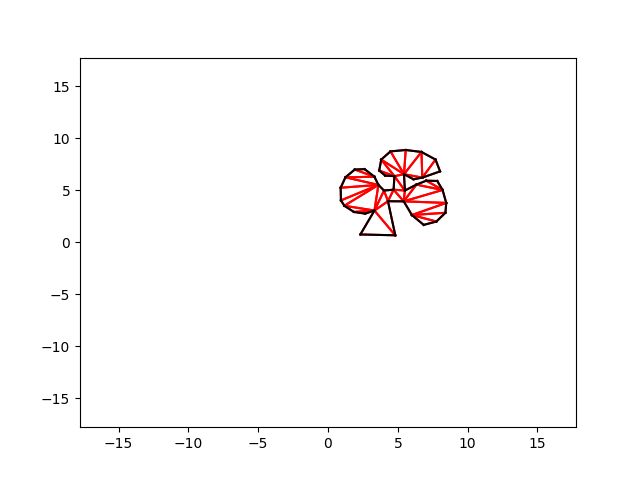

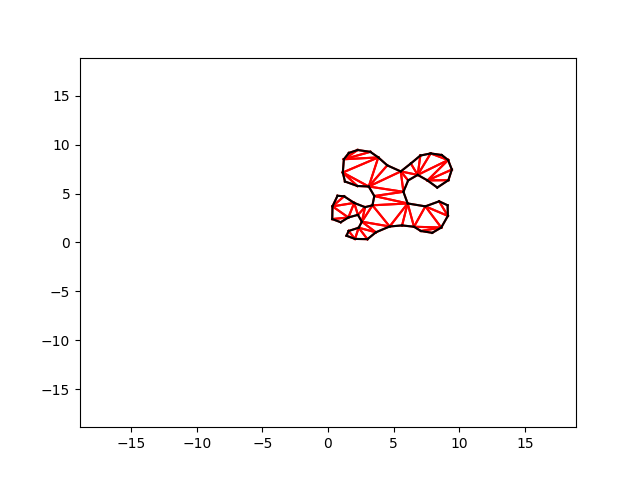

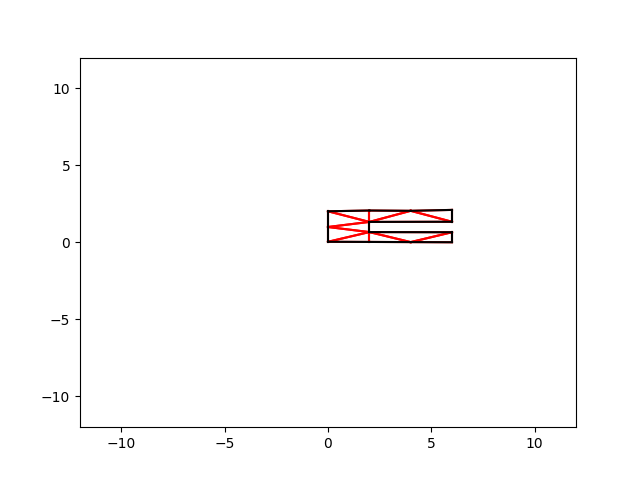

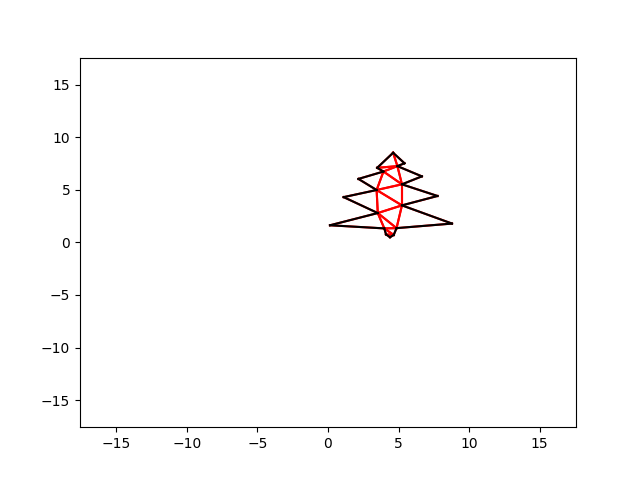

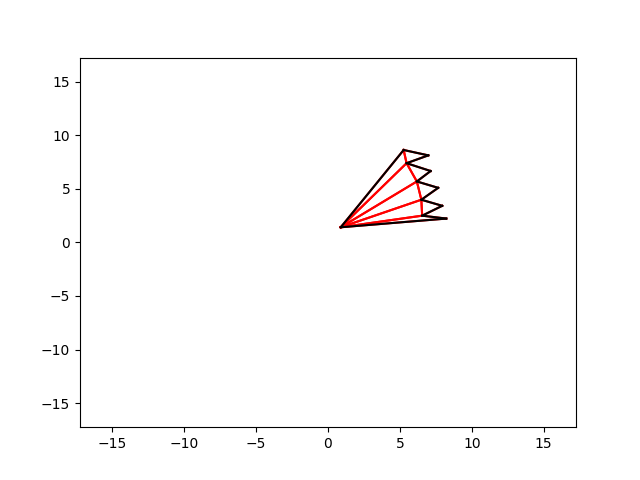

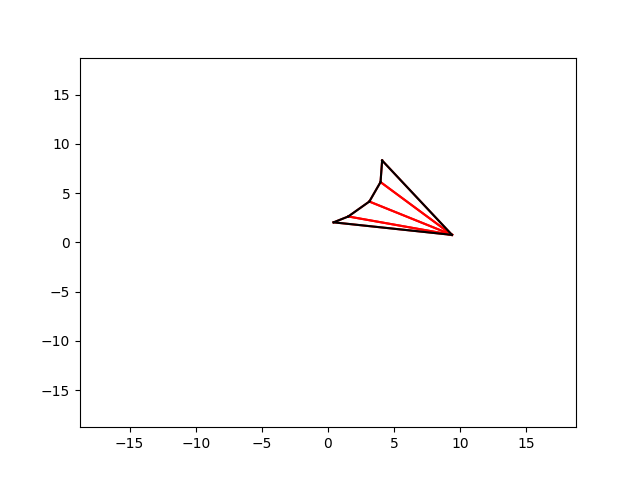

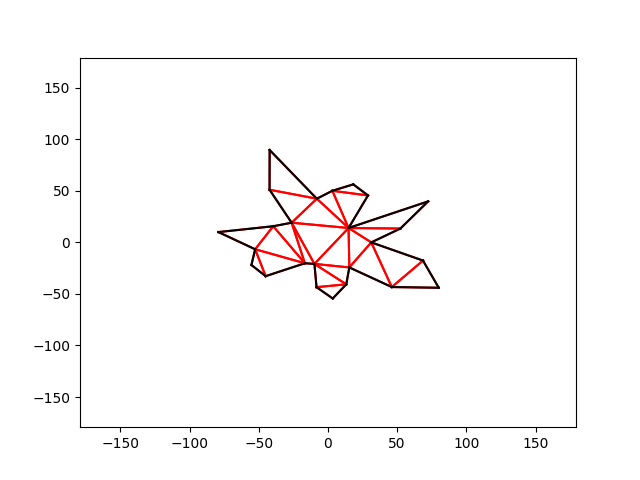

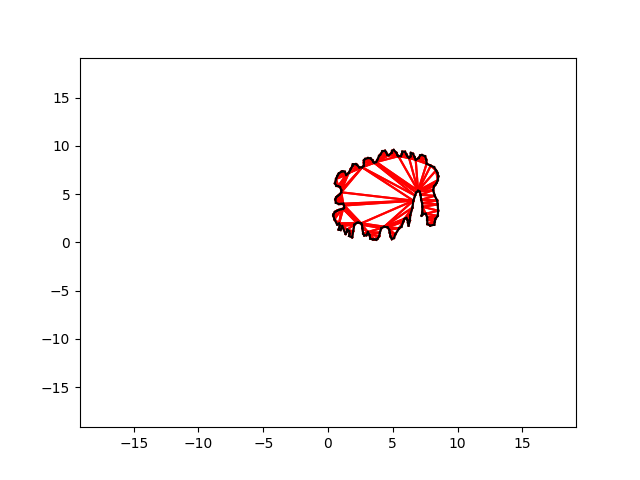

FileNotFoundError: [Errno 2] No such file or directory: 'test_polygon9.txt'

In [36]:
for i in range(8):
    input = read_polygon_from_file('test_polygon'+str(i+1)+'.txt')
    D=Delaunay(input)
    D.performAlgoritm()
    D.draw_final_Triangularization()

input = read_polygon_from_file('test_perf'+str(3)+'.txt')
D=Delaunay(input)
D.performAlgoritm()
D.draw_final_Triangularization()

input = read_polygon_from_file('test_perf'+str(4)+'.txt')
D=Delaunay(input)
D.performAlgoritm()
D.draw_final_Triangularization()

input = read_polygon_from_file('test_perf'+str(2)+'.txt')
D=Delaunay(input)
D.performAlgoritm()
D.draw_final_Triangularization()

input = read_polygon_from_file('test_perf'+str(1)+'.txt')
D=Delaunay(input)
D.performAlgoritm()
D.draw_final_Triangularization()





